In [228]:
# @title
### EP2 MAC0417 / MAC5768
##################################################################
# AO PREENCHER ESSE CABEÇALHO COM O MEU NOME E O MEU NÚMERO USP, #
# DECLARO QUE SOU O ÚNICO AUTOR E RESPONSÁVEL PELA RESOLUÇÃO     #
# DESTE EP.                                                      #
# TODAS AS PARTES FORAM DESENVOLVIDAS E IMPLEMENTADAS POR MIM,   #
# SEGUINDO AS INSTRUÇÕES E QUE PORTANTO, NÃO CONSTITUEM          #
# DESONESTIDADE ACADÊMICA OU PLÁGIO.                             #
#                                                                #
# DECLARO TAMBÉM, QUE SOU RESPONSÁVEL POR TODAS AS CÓPIAS        #
# DESSE PROGRAMA, E QUE EU NÃO DISTRIBUI OU FACILITEI A          #
# SUA DISTRIBUIÇÃO. ESTOU CIENTE QUE OS CASOS DE PLÁGIO E        #
# DESONESTIDADE ACADÊMICA SERÃO TRATADOS SEGUNDO OS CRITÉRIOS    #
# DEFINIDOS NO CÓDIGO DE ÉTICA DA USP.                           #
#                                                                #
# ENTENDO QUE JUPYTER NOTEBOOKS SEM ASSINATURA NÃO SERÃO         #
# CORRIGIDOS E, AINDA ASSIM, PODERÃO SER PUNIDOS POR             #
# DESONESTIDADE ACADÊMICA.                                       #
#                                                                #
#                                                                #
# Nome : Vítor Garcia Comissoli                                  #
# NUSP : 11810411                                                #
# Turma: 2024145                                                 #
# Prof.: Ronaldo Fumio Hashimoto                                 #
##################################################################

# **EP02-1**

*   Vítor Garcia Comissoli - NUSP: 11810411

## **Links relevantes:**

*   Link para o GitHub: https://github.com/Vitor-Garcia-Comissoli/Codes_from_MAC0417
*   Link para a pasta do Google Drive: https://drive.google.com/drive/folders/1ubIiGba3zHnV96B1JR5jz7j8Usq4PoZH?usp=drive_link


## Carregamento das bibliotecas ##

In [229]:
import skimage
import cv2
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import ndimage
from time import time
from skimage import io
from skimage.transform import resize
from joblib import Parallel, delayed
import gc
from google.colab import drive
import os
import math
from random import choice
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [230]:
t00 = time()

In [231]:
# Coletor de lixo para otimização da memória:
gc.enable()

### **Input dos arquivos necessários:**

##### **Input pelo Google Drive:**
Inicialmente, deve ser criado um atalho da pasta do Google Drive (fornecida através do link anteriormente) para o Drive do usuário. Em seguida, através do código a seguir, o Google Colab é conectado ao Drive, é montada uma pasta e alterado o diretório da pasta.

##### **Input da pasta baixada localmente:**
Alternativamente, caso tenha baixado o .ipynb, estabelecer uma path para a pasta "EP01" (encontrada no repositório do GitHub), e renomeá-la "EPs".

In [232]:
# Montando a pasta:
from google.colab import drive
drive.mount('/content/gdrive')

path = '/content/gdrive/My Drive/Nono Semestre/MAC 0417/EPs/EPs'

# Descomentar essa linha, e comentar a anterior, após copiar a pasta para o drive pessoal:
# path = '/content/gdrive/My Drive/EPs'

# Descomentar essa linha, e comentar as anteriores, para usar o arquivo baixado nativamente:
# path = 'F:/Downloads/EPs'

# Alterando o diretório:
import os
os.chdir(path)

# Listando os arquivos do diretório:
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
 Anel		   'Carta de Baralho'  'Fone Bluetooth'    Metadados.xlsx	 Pendrive
 augmentedDataset   EP01.ipynb	        Lápis		   Mouse		'SD Card'
 Caneta		    EP02-1.ipynb        Lapiseira	   normalizedDataset
 Canivete	    EP02-2.ipynb        Metadados.gsheet   originalGrayDataset


## Metadados ##

In [233]:
# Tabela principal:
metadados = pd.read_excel('Metadados.xlsx')
%load_ext google.colab.data_table
metadados

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


index  name_jpg  class  obj_number  repeticao  plano_de_fundo  iluminacao
0        1   A_ama_1      1           1          1               4           4
1        2   A_bra_1      1           1          1               4           2
2        3   A_esc_1      1           1          1               4           1
3        4  A_roxo_1      1           1          1               4           3
4        5   B_ama_1      1           1          1               2           4
..     ...       ...    ...         ...        ...             ...         ...
475    476  C_roxo_3     10           1          3               3           3
476    477   P_ama_3     10           1          3               1           4
477    478   P_bra_3     10           1          3               1           2
478    479   P_esc_3     10           1          3               1           1
479    480  P_roxo_3     10           1          3               1           3

[480 rows x 7 columns]

In [234]:
# Tabela com as informações das classes:
classes = pd.read_excel('Metadados.xlsx', sheet_name='Classe')
classes

index  codigo              desc abrv
0      0       1             Mouse    M
1      1       2           SD Card   SD
2      2       3         Lapiseira  LSR
3      3       4            Caneta  CNT
4      4       5             Lápis  LPS
5      5       6          Pendrive   PD
6      6       7          Canivete  CNV
7      7       8              Anel    A
8      8       9  Carta de Baralho   CB
9      9      10    Fone Bluetooth   FB

## Nota sobre paralelização de loops ##

Para maior eficiência e uso de todos os processadores disponíveis, a biblioteca joblib foi utilizada para aplicar as funções em larga escala. A implementação foi baseada no seguinte tutorial:

https://scikit-image.org/docs/stable/user_guide/tutorial_parallelization.html

## 1. RGB2gray (converter as imagens RGB originais em níveis de cinza)##

Converte uma imagem RGB para níveis de cinza em 8-bits por pixel. Reduz as dimensões da imagem original pela metade. Apoia-se nas funções nativas do skimage.

Documentação da rgb2gray do skimage: https://scikit-image.org/docs/dev/api/skimage.color.html#skimage.color.rgb2gray

Documentação da resize do skimage: https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize

Documentação da img_as_ubyte do skimage: https://scikit-image.org/docs/stable/api/skimage.html#skimage.img_as_ubyte

In [235]:
def rgbparacinza(imagem):
  '''
  (numpy.ndarray) -> numpy.ndarray
  Recebe uma imagem RGB e a transforma para uma imagem em níveis de cinza.
  Além disso, reduz as dimensões da imagem para metade das dimensões originais
  e retorna um numpy.ndarray com 8-bits por pixel, ou seja, do tipo np.uint8.

  Dependências: skimage, skimage.transform.resize, numpy as np
  '''

  # Converte para níveis de cinza:
  im_cinza = skimage.color.rgb2gray(imagem)

  # Aplica o resize - diminuindo para metade das dimensões originais:
  im_cinza = resize(im_cinza, output_shape = (im_cinza.shape[0]//2,im_cinza.shape[1]//2), anti_aliasing = False)

  # Muda o tipo de dado para np.uint8:
  im_cinza = skimage.util.img_as_ubyte(im_cinza)

  return im_cinza

## 2. Contrast Stretching ##

A função recebe uma imagem em níveis de cinza de dimensão n linhas por m colunas e 8-bits por pixel (range de 0 a 255). Retorna uma imagem que realiza o "Contrast Stretching" por meio da operação OUT = INPUT - MIN(INPUT) * STRETCH, pixel a pixel, onde STRETCH = 255 / MAX(INPUT - MIN(INPUT)) .

In [236]:
def contrast_stretching(imagem):
  '''
  (numpy.ndarray,numpy.ndarray) -> numpy.ndarray
  Recebe uma imagem (imagem) em níveis de cinza com 8-bits por pixel.

  É retornada o contrast streching por meio da operação:
  OUTPUT = (IMAGEM - MIN(IMAGEM)) * STRETCH, onde STRETCH = 255 / MAX(IMAGEM - MIN(IMAGEM))

  A imagem OUTPUT é convertida para 8-bits por pixel (no range(0,255)).

  Dependências: numpy as np, skimage.
  '''

  # Obtendo as intensidades máxima e mínima da imagem:
  min = imagem.min()
  max = imagem.max()

  # Translocando a imagem para que a intensidade mínima seja 0:
  out = (imagem - min)

  # Obtendo o valor a ser "streatched":
  stretch = 255 / (out.max())

  # Realizando o streatching:
  out = out * stretch

  # Muda o tipo de dado para np.uint8:
  out = np.array(out, dtype = np.uint8)

  return out

## 3. Logaritmo natural da imagem ##

Utilizou-se a função nativa adjust_log do skimage, que aplica a transformação OUTPUT = LN (1 + INPUT).

A documentação dessa função pode ser acessada através do link: https://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.adjust_log

In [237]:
def logaritmo_imagem(imagem):
  '''
  (numpy.ndarray) -> numpy.ndarray
  Recebe uma imagem (imagem) em níveis de cinza com 8-bits por pixel.

  É retornada o logaritmo natural da imagem por meio da operação:

  OUTPUT = LN(1+INPUT)

  Na equação acima, INPUT é convertido internamente para o range(0,1).

  A imagem OUTPUT é convertida para 8-bits por pixel (no range(0,255)).

  Dependências: skimage, numpy as np
  '''

  # Aplica a transformação logarítmica:
  out = skimage.exposure.adjust_log(imagem)

  # Muda o tipo de dado para np.uint8:
  out = np.array(out, dtype = np.uint8)

  return out

## 4. Exponencial da imagem ##

Essa função aplica a seguinte transformação para cada imagem de entrada:

OUT = 255 * (exp(IN / 255) - 1) / (e - 1)

Ou seja, a escala da imagem de entrada é convertida para (0, 1) por meio da
operação:

IN = IN / 255

Após isso, a exponencial foi aplicada à imagem, obtendo uma saída no range (1, e):

OUT = exp(IN)

A saída foi renormalizada para o range (0, 1), por meio da operação:

OUT = (OUT - 1) / (e - 1)

Por fim, a saída possui novamente range (0, 255), através da multiplicação por 255.

In [238]:
def exponencial_imagem(imagem):
  '''
  (numpy.ndarray) -> numpy.ndarray
  Recebe uma imagem (imagem) em níveis de cinza com 8-bits por pixel.

  É retornada o logaritmo natural da imagem por meio da operação:

  OUTPUT = exp(INPUT)

  Na equação acima, INPUT é convertido internamente para o range(0,1).

  A imagem OUTPUT é convertida para 8-bits por pixel (no range(0,255)).

  Dependências: numpy as np, skimage, math
  '''

  # Aplica a função OUT = 255 * (exp(IN/255)-1)/(e-1):
  out = 255*(np.exp(imagem/255, dtype = np.float64)-1)/(math.e-1)

  # Muda o tipo de dado para np.uint8:
  out = np.array(out, dtype = np.uint8)

  return out

## 5. Laplaciano da Imagem ##


In [239]:
def laplaciano_imagem(imagem):
  '''
  (numpy.ndarray) -> numpy.ndarray
  Recebe uma imagem (imagem) em níveis de cinza com 8-bits por pixel.

  É retornado o laplaciano da imagem calculada através da convolução com um kernel de 4 vizinhos:

  A imagem OUTPUT é convertida para 8-bits por pixel (no range(0,255)).

  Dependências: numpy as np, skimage, cv2
  '''

  # Calcula o laplaciano usando um kernel de 4 vizinhos:
  out = cv2.Laplacian(imagem, cv2.CV_64F, ksize=1)

  # Muda o tipo de dado para np.uint8:
  out = np.array(out, dtype = np.uint8)

  return out


## 6. Filtro da média usando convolução ##

O filtro da média é aplicado a partir de convolução com um vetor de pesos (weights) de dimensões 9x9 e zero-padding. Usamos como base a função convolve do scipy.

A documentação da convolve pode ser acessada através do link: https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.convolve.html

In [240]:
def filtro_media(imagem):
  '''
  (numpy.ndarray) -> numpy.ndarray
  Recebe uma imagem (imagem) em níveis de cinza com 8-bits por pixel.

  É retornado o filtro da média da imagem de entrada usando convolução,
  uma janela de dimensões 9x9 e zero-padding.

  Dependências: numpy as np, scipy.ndimage, skimage
  '''

  # Matriz de pesos ('weights'):
  k = np.full(shape = (9,9), fill_value = 1/81)

  # Aplica a convolução:
  out = ndimage.convolve(input = imagem, weights = k, mode = 'constant', cval = 0.0)

  # Muda o tipo de dado para np.uint8:
  out = np.array(out, dtype = np.uint8)

  return out

## 7. Funções gerais para aplicação dos filtros ##

As funções a seguir serão usadas tanto no EP02-1 quanto EP02-2. As mesmas realizam diversas tarefas que são comuns aos filtros, são elas:

* Criam um novo diretório (e todos os diretórios intermediários) para cada filtro que será aplicado . Verificam, também, se o diretório necessário já está criado.

* Lêem as imagens-base (colorida para o filtro 'rgbparacinza' e em escala de cinza para todos os outros filtros), aplicam o filtro e escrevem a nova imagem na pasta correspondente. O nome da imagem transformada também é relacionado com a sua transformação.

* Cronometram e imprimem ao usuário os tempos para a realização de determinada tarefa para determinada pasta.

In [241]:
def cria_dataset(diretorio_original, tipo):
  ''' (str, str) -> None
  Essa função recebe duas strings: diretorio_original e tipo. Ela simplesmente
  cria uma pasta com o nome 'tipo' dentro de diretorio_original. Os valores que
  'tipo' irá receber são diversos: originalGrayDataset, augmentedDataset,
  normalizedDataset, os nomes das diferentes classes (Anel, Caneta, etc) ou dos
  filtros específicos (Exp, Log, Lap, Norm, Con, Med).
  Dependência: os
  '''

  if not os.path.exists(diretorio_original + tipo):
    path = diretorio_original+tipo
    os.makedirs(path)


In [242]:
diretorio_final = '/content/gdrive/My Drive/Nono Semestre/MAC 0417/EPs/EPs'

# Criando os datasets 'originalGrayDataset' e 'augmentedDataset':
cria_dataset(diretorio_final,'originalGrayDataset' )
cria_dataset(diretorio_final,'augmentedDataset' )

In [243]:
# Lista de filtros:
lista_filtros = [contrast_stretching, logaritmo_imagem, exponencial_imagem, laplaciano_imagem, filtro_media]

# Dicionário de funções que relaciona o filtro aplicado ao nome da pasta
# correspondente e à extensão do arquivo transformado:
filtros = {rgbparacinza: 'cin', contrast_stretching: 'con', logaritmo_imagem:'log',
           exponencial_imagem: 'exp', laplaciano_imagem: 'lap', filtro_media:'med'}

In [244]:
def aplica_filtro(tipo_filtro , diretorio_original, diretorio_final, classe, dicionario_filtros = filtros):
  ''' (function, str, str, str,dict) -> None.
  Essa função é o coração do EP. A mesma recebe uma função de filtro ('tipo_filtro')
  e aplica a mesma para todas as imagens da classe 'classe' que estiverem na
  pasta 'diretorio_original', escrevendo-as na pasta 'diretorio_final'.

  No ato de aplicar os filtros, essa função utiliza o dicionário 'dicionario_filtros'
  para criar pastas com os nomes das transformações dentro das pastas das classes
  no 'diretorio_final', além de escrever as extensões corretas no nome final.

  No caso da transformação em níveis de cinza, não foi criada uma nova pasta nos
  diretórios de classes por ser considerada supérflua.

  Exemplo de aplicação 1:
  >>> aplica_filtro(tipo_filtro = rgbparacinza,
  diretorio_original = '/content/gdrive/My Drive/Nono Semestre/MAC 0417/EPs/EPs',
  diretorio_final = '/content/gdrive/My Drive/Nono Semestre/MAC 0417/EPs/EPs'/originalGrayDataset/',
  classe = 'Anel')
  #Lê todas as imagens que estiverem na pasta '/content/gdrive/My Drive/Nono Semestre/MAC 0417/EPs/EPs'/Anel'
  #Aplica a transformação rgbparacinza em cada imagem com nome, por ex., 'exemplo.jpg'
  #Acessa a chave correspondente a rgbparacinza em dicionario_filtros (padrão: 'cin')
  #Escreve a imagem transformada na pasta '/content/gdrive/My Drive/Nono Semestre/MAC 0417/EPs/EPs'/originalGrayDataset/Anel'
  #Com o nome 'exemplo-cin.jpg'

  Exemplo de aplicação 2:
  >>> aplica_filtro(tipo_filtro = logaritmo_imagem,
  diretorio_original = '/content/gdrive/My Drive/Nono Semestre/MAC 0417/EPs/EPs'/originalGrayDataset/',
  diretorio_final = '/content/gdrive/My Drive/Nono Semestre/MAC 0417/EPs/EPs'/augmentedDataset/',
  classe = 'Anel')
  #Lê todas as imagens que estiverem na pasta '/content/gdrive/My Drive/Nono Semestre/MAC 0417/EPs/EPs'/originalGrayDataset/Anel/'
  #Aplica a transformação logaritmo_imagem em cada imagem com nome, por ex., 'exemplo-cin.jpg'
  #Acessa a chave correspondente a logaritmo_imagem em dicionario_filtros (padrão: 'log')
  #Escreve a imagem transformada na pasta '/content/gdrive/My Drive/Nono Semestre/MAC 0417/EPs/EPs'/augmentedDataset/Anel/log/'
  #Com o nome 'exemplo-cin-log.jpg'

  Dependências: gc, time.time, from pathlib import Path, skimage.io, os, skimage, random.choice
  '''

  # Coletor automático de lixo:
  gc.enable()

  # Tempo para aplicação da função:
  t0 = time()

  # Transformando a string do diretório de entrada em um objeto Path:
  folder_entrada = Path(f"{diretorio_original}/{classe}/")

  # Extensão dos arquivos e nomes das novas pastas:
  extensao = dicionario_filtros[tipo_filtro]

  # Criando e nomeando a nova pasta:
  if tipo_filtro != rgbparacinza:
    cria_dataset(diretorio_final, f"{classe}/{extensao}/")
    nova_pasta = Path(f"{diretorio_final}/{classe}/{extensao}/")
  else:
    # Se a transformação for para níveis de cinza, não é necessário usar a extensão
    cria_dataset(diretorio_final, f"/{classe}")
    nova_pasta = Path(f"{diretorio_final}/{classe}/")

  # Listando as imagens na pasta original:
  nomes_imagens = os.listdir(folder_entrada)

  for nome_imagem in nomes_imagens:
    # Lendo a imagem de entrada:
    imagem_entrada = io.imread(f"{folder_entrada}/{nome_imagem}")

    # Aplicando o filtro:
    imagem_saida = tipo_filtro(imagem_entrada)

    # Escrevendo a imagem de saída no diretório correto com a extensão correta:
    os.chdir(nova_pasta)
    io.imsave(f"{nome_imagem[:-4]}-{extensao}.jpg", imagem_saida)

    del imagem_entrada, imagem_saida

  del nomes_imagens

  # Tempo para aplicação da função:
  t1 = time()
  print(f"Tempo para aplicação do filtro '{extensao}' para a pasta {folder_entrada}: {(t1-t0):.3f}s")

In [245]:
# Aplicando a transformação para níveis de cinza:
Parallel(n_jobs=-1, verbose = 1)(delayed(aplica_filtro)(tipo_filtro = rgbparacinza, diretorio_original = diretorio_final, diretorio_final = f"{diretorio_final}/originalGrayDataset/",classe = classe) for classe in classes['desc'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.0min finished


[None, None, None, None, None, None, None, None, None, None]

In [246]:
# Aplicando as demais transformações:
for filtro in lista_filtros:
  Parallel(n_jobs=-1, verbose = 1)(delayed(aplica_filtro)(tipo_filtro = filtro, diretorio_original = f"{diretorio_final}/originalGrayDataset/", diretorio_final = f"{diretorio_final}/augmentedDataset/" , classe = classe) for classe in classes['desc'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   17.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   27.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   22.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   25.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.5min finished


## Tempo de execução do notebook ##

In [247]:
t11 = time()
tempo_em_horas = (t11-t00)//3600
sobra = (t11-t00)%3600
tempo_em_minutos = sobra//60
tempo_em_segundos = sobra%60
print(f"Tempo de execução do notebook: {tempo_em_horas} h {tempo_em_minutos} min {tempo_em_segundos} s")

Tempo de execução do notebook: 0.0 h 5.0 min 5.196313858032227 s


## 8. Visualização do augmentedDataset ##
Para visualização dos resultados do augmentedDataset, de como os filtros descritos e implementados influenciaram na transformação das imagens, um exemplo de cada classe foi aleatoriamente selecionado e mostrado a seguir através de um MNIST-LIKE.

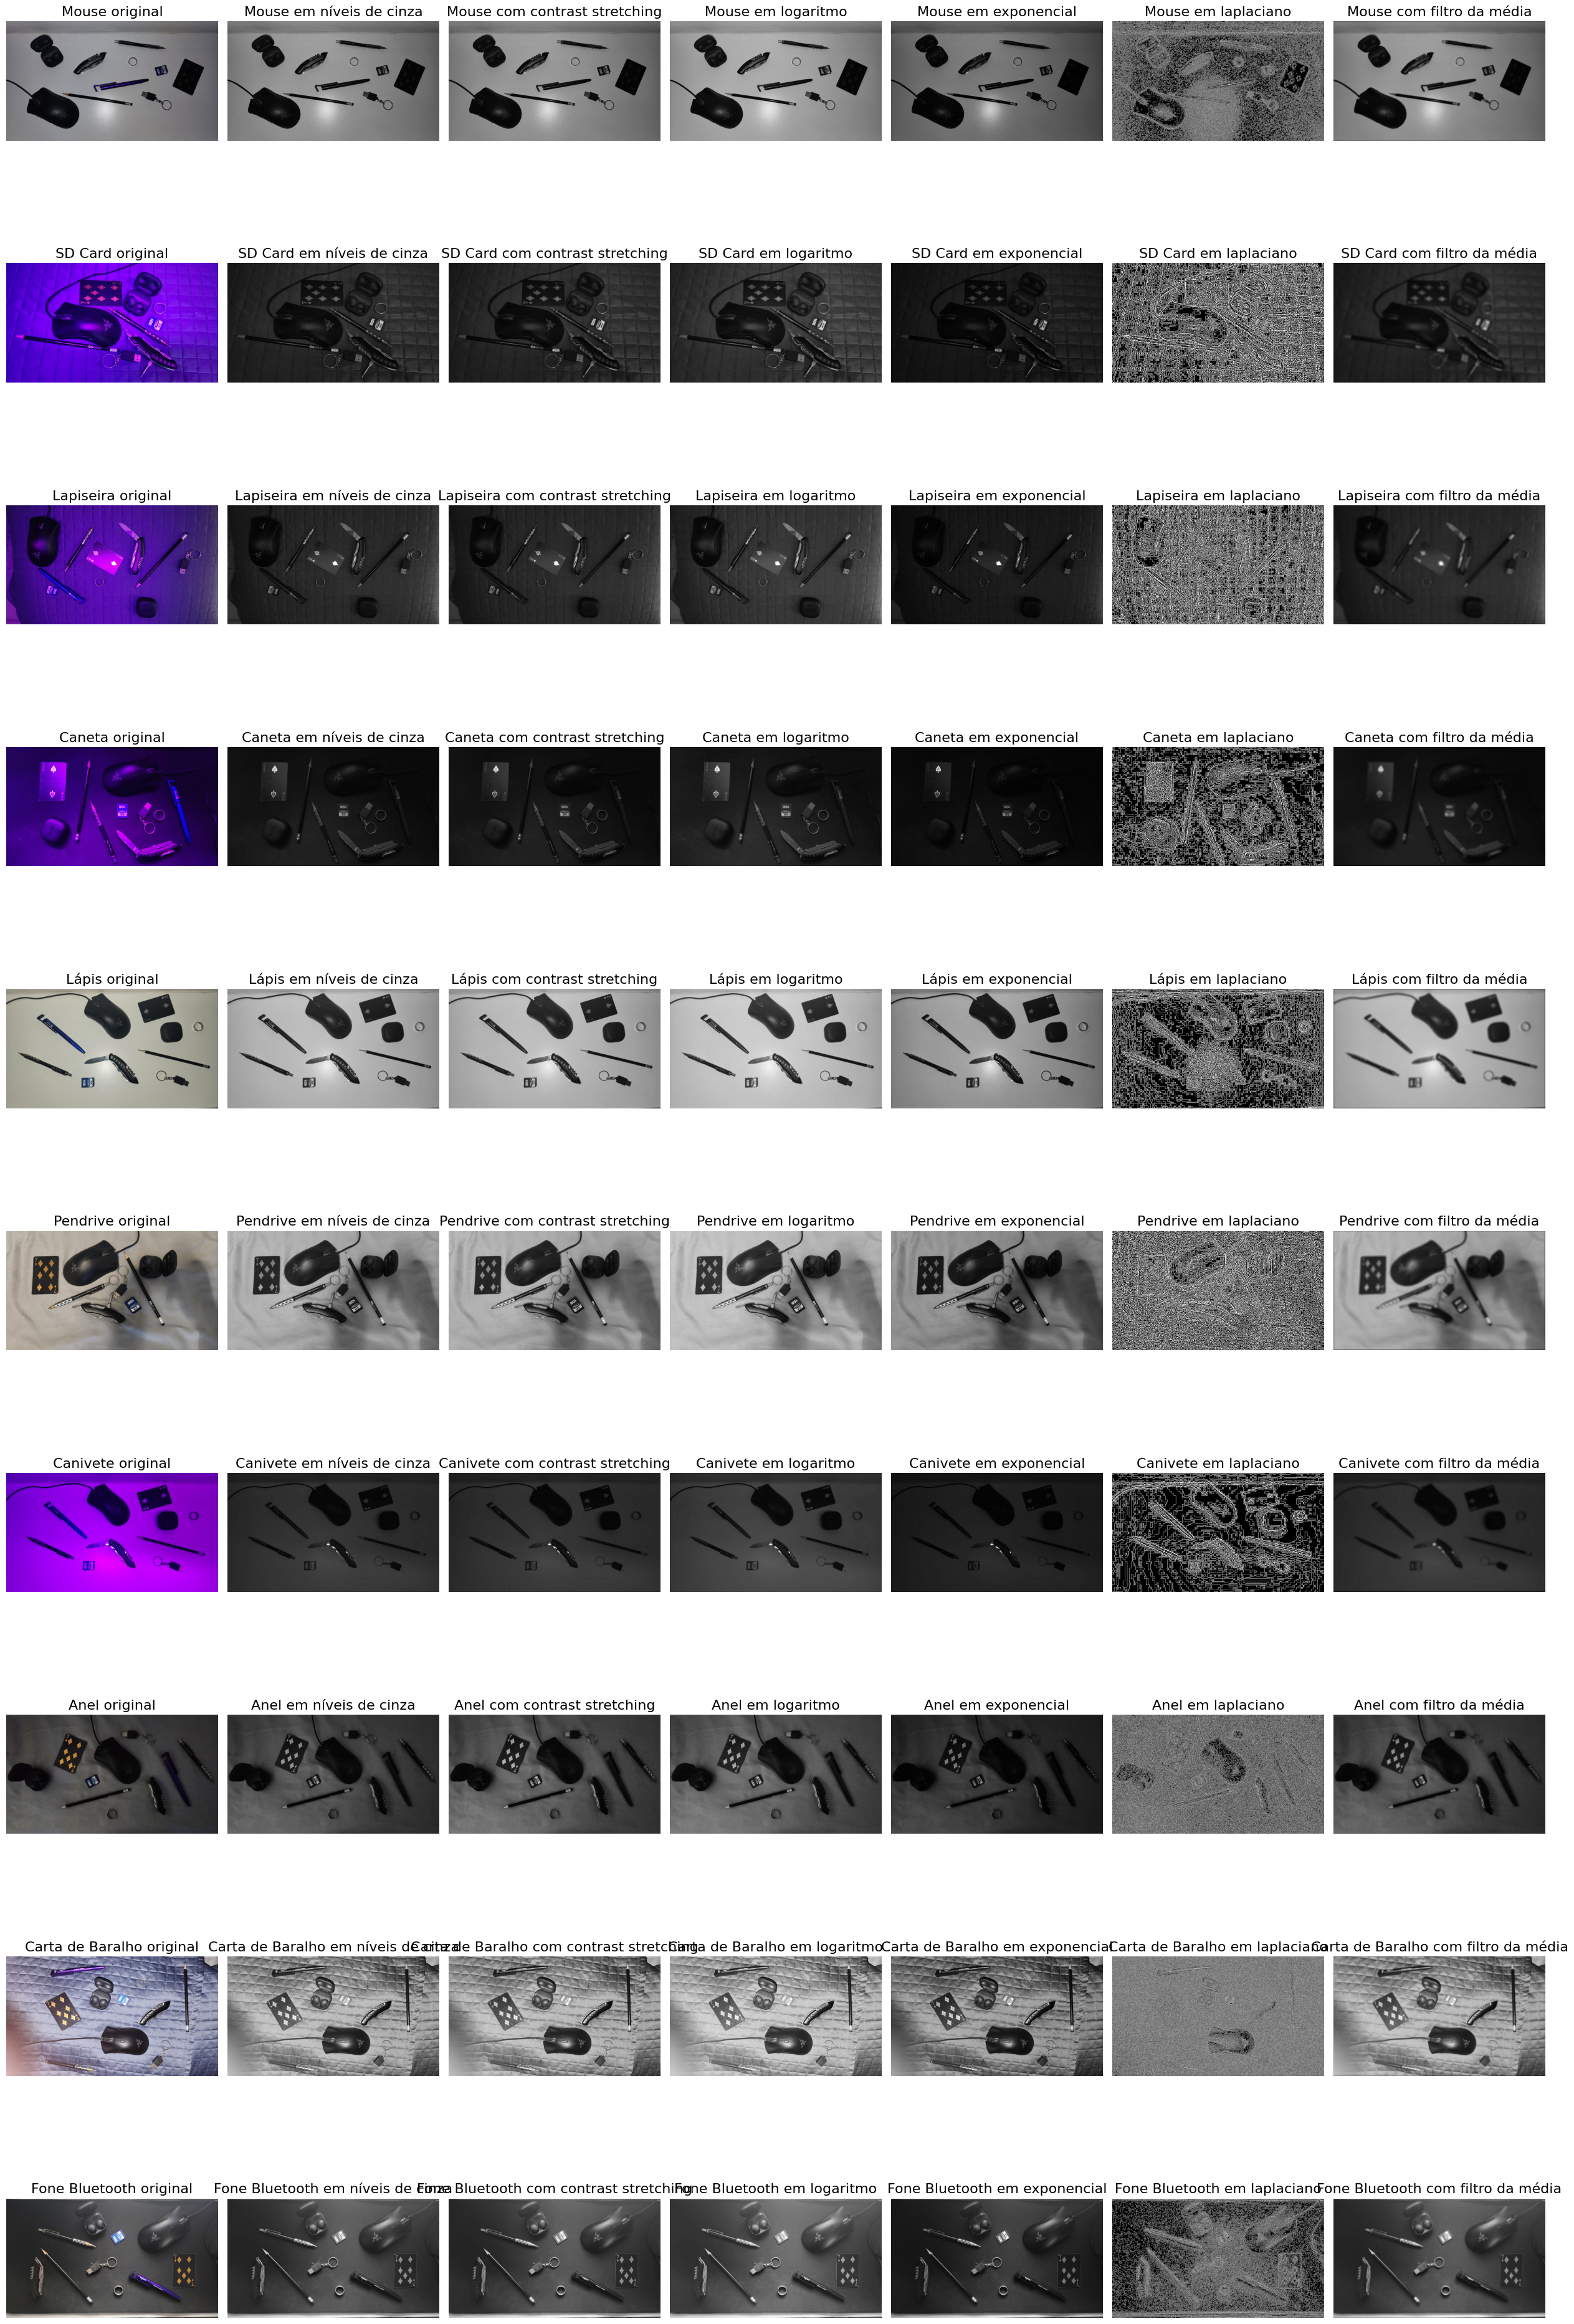

In [248]:
diretorio_final = '/content/gdrive/My Drive/Nono Semestre/MAC 0417/EPs/EPs/'
lista_extensoes = ['con', 'log', 'exp', 'lap', 'med']
classes = pd.read_excel('Metadados.xlsx', sheet_name='Classe')

# Sorteando e lendo uma imagem de cada classe com todos os filtros:
imagens = {}
for i in range(classes.shape[0]):
  classe = classes.iloc[i]['desc']
  nome_imagem = random.sample(os.listdir(diretorio_final + 'originalGrayDataset/' + classe), 1)[0]
  imagens[classe] = [io.imread(diretorio_final + classe + '/' + nome_imagem[:nome_imagem.index("-")] + '.jpg'), io.imread(diretorio_final + 'originalGrayDataset/' + classe + '/' + nome_imagem)]
  for ext in lista_extensoes:
    imagens[classe].append(io.imread(diretorio_final + 'augmentedDataset/' + classe + '/' + ext + '/' + nome_imagem[:nome_imagem.index(".")] + '-' + ext + '.jpg'))

# Plot:
titulos = [" original", " em níveis de cinza", " com contrast stretching", " em logaritmo", " em exponencial", " em laplaciano", " com filtro da média"]

fig, axs = plt.subplots(classes.shape[0], len(titulos), figsize=(25, 40))
for i in range(classes.shape[0]):
  classe = classes.iloc[i]['desc']
  for j in range(len(titulos)):
    if j == 0:
      axs[i,j].imshow(imagens[classe][j])
    else:
      axs[i,j].imshow(imagens[classe][j], cmap='gray', vmin=0, vmax=255)
    axs[i,j].set_title(classe + titulos[j], fontsize=16)
    axs[i,j].axis('off')
plt.tight_layout()
plt.show()


## 9. Tabela global sumária ##

Uma versão ligeiramente modificada da função do EP01 foi utilizada para obter algumas medidas em resumo, dos dados do originalGrayDataset + augmentedDataset.

In [249]:
descricao_tgs = ['Nome das classes','Número de classes', 'Número de imagens', 'Tamanho da base (MB)']
c = ''
for j in range(len(classes['desc'])-1):
  c += classes["desc"][j] + ', '
c += classes["desc"][j+1]
valores_tgs = [c, classes.shape[0], 6*metadados["name_jpg"].nunique()] # Número total de classes e número total de amostras

diretorio = '/content/gdrive/My Drive/Nono Semestre/MAC 0417/EPs/EPs/originalGrayDataset/'
classes_descr = []
for i in range(classes.shape[0]): # Criação dos atributos da tabela global sumária
  classe = classes.iloc[i]['desc']
  classes_descr.append(classe)
  abreviacao = classes.iloc[i]['abrv']
  nome = metadados.iloc[i]['name_jpg']
  im = io.imread(diretorio + classe + '/' + nome + '-cin'+ '.jpg')
  descricao_tgs.append('Resolução imagens de ' + classe)
  valores_tgs.append(str(im.shape[0]) + ' x ' + str(im.shape[1]))  # Resolução

tamanho = 0
for root, dirs, files in os.walk('/content/gdrive/My Drive/Nono Semestre/MAC 0417/EPs/EPs/originalGrayDataset'):
  tamanho += sum([os.path.getsize(os.path.join(root,name)) for name in files])
for root, dirs, files in os.walk('/content/gdrive/My Drive/Nono Semestre/MAC 0417/EPs/EPs/augmentedDataset'):
  tamanho += sum([os.path.getsize(os.path.join(root,name)) for name in files])

valores_tgs.insert(3, round(tamanho/(10**6)))  # Tamanho da base em MB

# Tabela global sumária:
tgs = pd.DataFrame(list(zip(descricao_tgs, valores_tgs)), columns = ['Descrição', 'Valor'])
tgs.set_index('Descrição')

Valor
Descrição                                                                               
Nome das classes                       Mouse, SD Card, Lapiseira, Caneta, Lápis, Pend...
Número de classes                                                                     10
Número de imagens                                                                    288
Tamanho da base (MB)                                                                 463
Resolução imagens de Mouse                                                   1126 x 2000
Resolução imagens de SD Card                                                 1126 x 2000
Resolução imagens de Lapiseira                                               1126 x 2000
Resolução imagens de Caneta                                                  1126 x 2000
Resolução imagens de Lápis                                                   1126 x 2000
Resolução imagens de Pendrive                                                1126 x 2000
Resolução imagens de Canivete                                                1126 x 2000
Resolução imagens de Anel                                                    1126 x 2000
Resolução imagens de Carta de Baralho                                        1126 x 2000
Resolução imagens de Fone Bluetooth                                          1126 x 2000